### Import Libraries

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns

2024-08-18 03:52:36.344337: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 03:52:36.344473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 03:52:36.510034: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load Dataset

In [3]:
# Path to the main folder
folder_path = "/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset"

In [4]:
# Subfolders and their labels
subfolders = ['Cloudy', 'Rain', 'Shine', 'Sunrise']
label_map = {subfolder: idx for idx, subfolder in enumerate(subfolders)}

# Prepare lists to hold images and labels
images = []
labels = []

# Load images and labels
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    for filename in os.listdir(subfolder_path):
        img_path = os.path.join(subfolder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img_resized = cv2.resize(img, (224, 224))  # Resize to 224x224
            images.append(img_resized)
            labels.append(label_map[subfolder])

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images.astype('float32') / 255.0

### Visualization

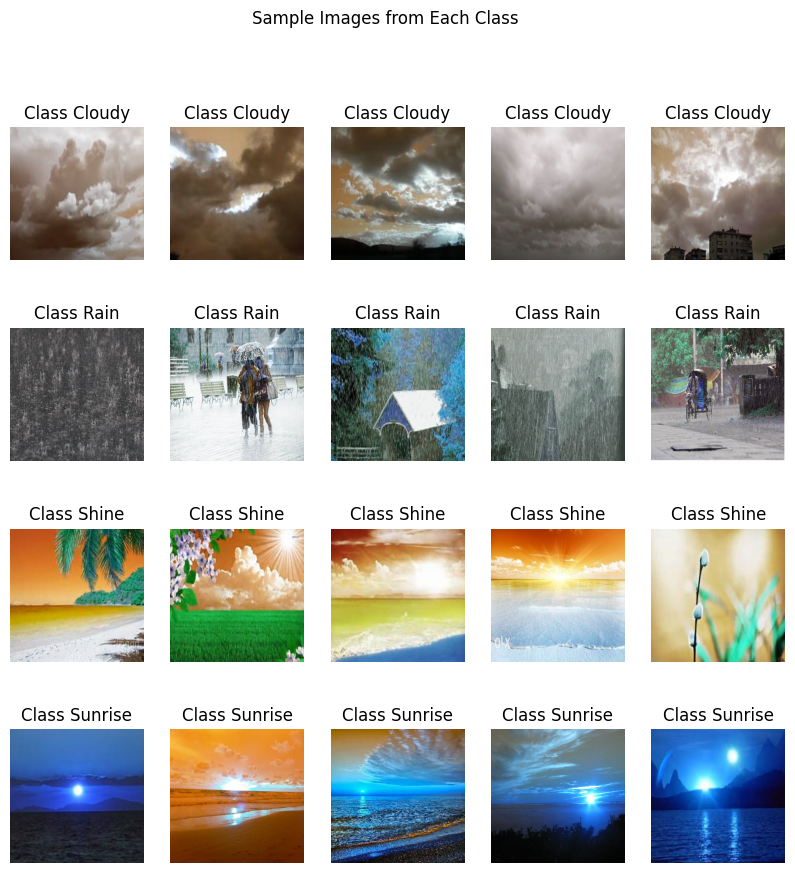

In [5]:
# Plot 5 images for each class
plt.figure(figsize=(10, 10))
for i, subfolder in enumerate(subfolders):
    class_indices = np.where(labels == label_map[subfolder])[0]
    for j in range(5):
        plt.subplot(len(subfolders), 5, i * 5 + j + 1)
        plt.imshow(images[class_indices[j]])
        plt.title(f'Class {subfolder}')
        plt.axis('off')
plt.suptitle('Sample Images from Each Class')
plt.show()

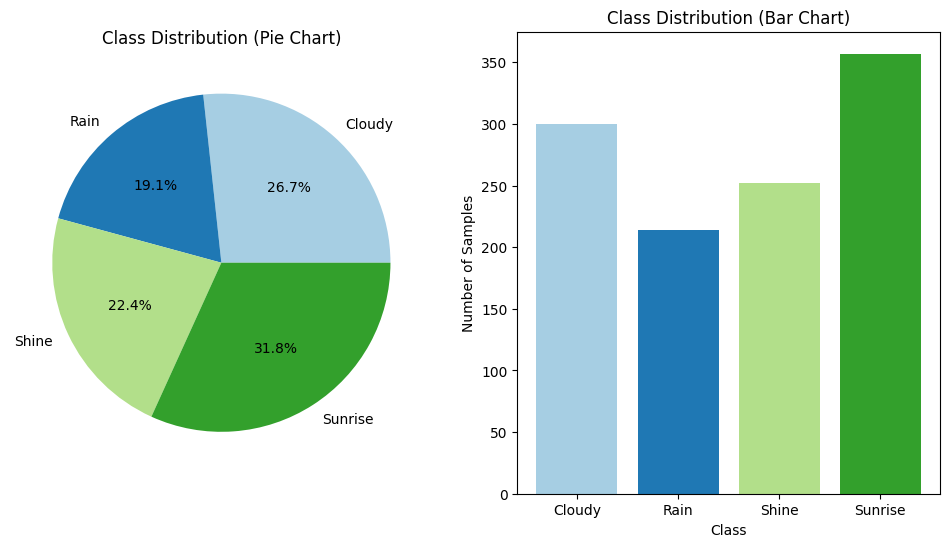

In [6]:
# Plot class distribution as a pie and bar chart
class_counts = np.bincount(labels)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(class_counts, labels=subfolders, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Class Distribution (Pie Chart)')

plt.subplot(1, 2, 2)
plt.bar(subfolders, class_counts, color=plt.cm.Paired.colors)
plt.title('Class Distribution (Bar Chart)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

plt.show()

### Split Dataset

In [7]:
# One-hot encode the labels
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=len(subfolders))

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

In [8]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(898, 224, 224, 3) (898, 4)
(225, 224, 224, 3) (225, 4)


### Building Model

In [32]:
# Build the CNN model with Dropout
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Add Dropout after first pooling layer

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Add Dropout after second pooling layer

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Add Dropout after third pooling layer

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),  # Add Dropout before final dense layer

    tf.keras.layers.Dense(len(subfolders), activation='softmax')
])


In [33]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,188,804 (42.68 MB)

 Trainable params: 11,188,804 (42.68 MB)

 Non-trainable params: 0 (0.00 B)

None


### Training

In [36]:
# Train the model and save the training history
history = model.fit(x_train, y_train, epochs=12, validation_data=(x_test, y_test))

Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.3799 - loss: 3.0538 - val_accuracy: 0.7511 - val_loss: 0.7310
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.7159 - loss: 0.6854 - val_accuracy: 0.7467 - val_loss: 0.6904
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.7800 - loss: 0.5415 - val_accuracy: 0.6756 - val_loss: 0.6887
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8129 - loss: 0.5038 - val_accuracy: 0.8133 - val_loss: 0.5175
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8746 - loss: 0.3797 - val_accuracy: 0.8622 - val_loss: 0.3985
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.8827 - loss: 0.3494 - val_accuracy: 0.8044 - val_loss: 0.4626
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.8810 - loss: 0.3336 - val_accuracy: 0.8844 - val_loss: 0.2932
Epoch 8/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.8691 - loss: 0.3548 - val_accuracy: 0.7733 - val_los

### Evaluate Model 

In [37]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')
print(f'Test loss: {test_loss}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 738ms/step - accuracy: 0.7875 - loss: 0.5270
Test accuracy: 0.800000011920929
Test loss: 0.5456122756004333


In [38]:
# Classification report
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=subfolders))

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 676ms/step
              precision    recall  f1-score   support

      Cloudy       0.59      0.97      0.73        61
        Rain       0.96      0.59      0.73        44
       Shine       0.91      0.57      0.70        53
     Sunrise       1.00      0.97      0.98        67

    accuracy                           0.80       225
   macro avg       0.87      0.77      0.79       225
weighted avg       0.86      0.80      0.80       225



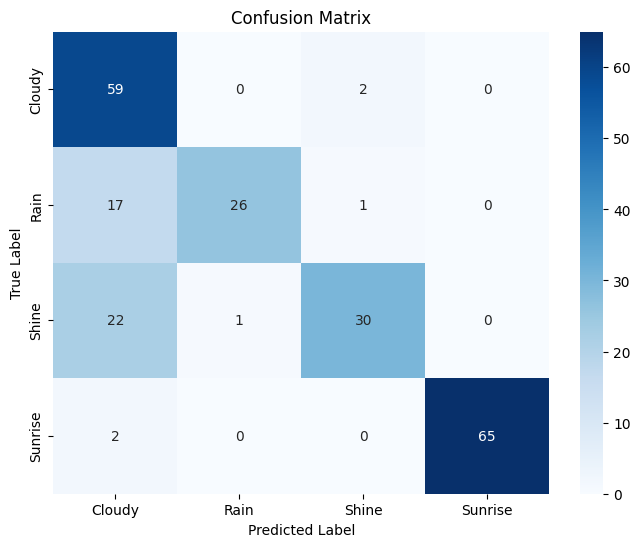

In [41]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=subfolders, yticklabels=subfolders)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Plotting History 

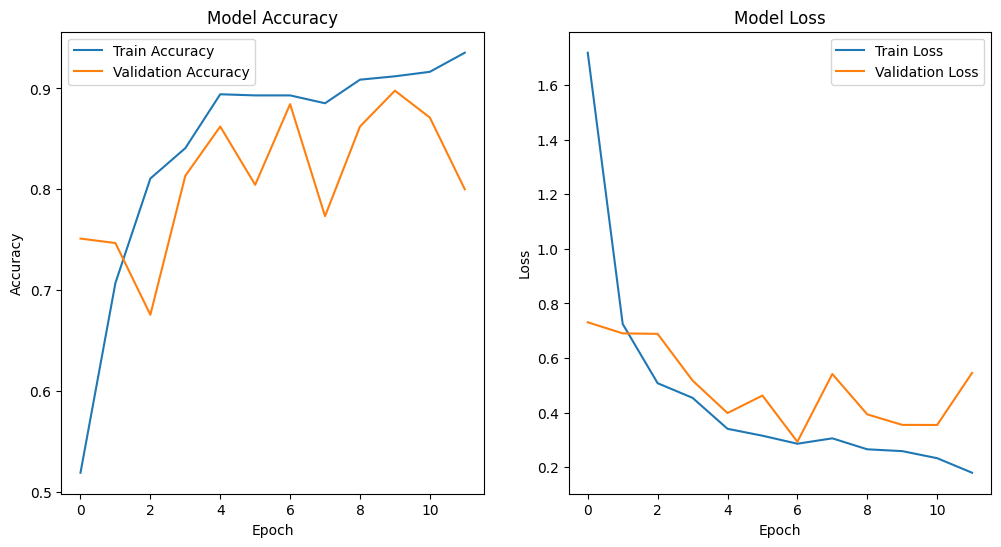

In [42]:
# Plot the history of model accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


### Model Testing 

In [20]:
# Function to predict and display results for multiple images
def predict_and_display_results(model, images, true_labels, subfolders, num_images=4):
    plt.figure(figsize=(12, 12))
    
    for i in range(num_images):
        # Select a random image from the test set
        index = np.random.randint(0, len(images))
        sample_image = images[index]
        true_label = np.argmax(true_labels[index])

        # Predict the probabilities for the selected image
        predictions = model.predict(np.expand_dims(sample_image, axis=0))
        predicted_label = np.argmax(predictions[0])

        # Format and print the probabilities with their corresponding labels
        formatted_probabilities = [f'Label {subfolders[i]}: {prob:.4f}' for i, prob in enumerate(predictions[0])]

        # Print the true label, predicted label, and all probabilities
        print(f'Image {i+1}:')
        print(f'True label: {subfolders[true_label]}')
        print(f'Predicted label: {subfolders[predicted_label]}')
        print('Probabilities for each class:')
        for label_prob in formatted_probabilities:
            print(label_prob)
        print()

        # Display the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(sample_image)
        plt.title(f'True: {subfolders[true_label]}\nPredicted: {subfolders[predicted_label]}')
        plt.axis('off')
    
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Image 1:
True label: Rain
Predicted label: Rain
Probabilities for each class:
Label Cloudy: 0.1810
Label Rain: 0.8137
Label Shine: 0.0050
Label Sunrise: 0.0003

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image 2:
True label: Sunrise
Predicted label: Sunrise
Probabilities for each class:
Label Cloudy: 0.0000
Label Rain: 0.0000
Label Shine: 0.0000
Label Sunrise: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image 3:
True label: Sunrise
Predicted label: Sunrise
Probabilities for each class:
Label Cloudy: 0.0000
Label Rain: 0.0000
Label Shine: 0.0000
Label Sunrise: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Image 4:
True label: Rain
Predicted label: Rain
Probabilities for each class:
Label Cloudy: 0.0986
Label Rain: 0.8897
Label Shine: 0.0093
Label Sunrise: 0.0023



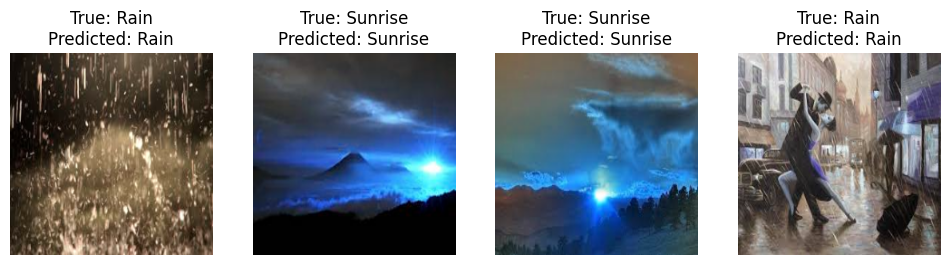

In [43]:
# Test the function with 4 images
predict_and_display_results(model, x_test, y_test, subfolders, num_images=4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image 1:
True label: Shine
Predicted label: Shine
Probabilities for each class:
Label Cloudy: 0.2627
Label Rain: 0.0088
Label Shine: 0.7073
Label Sunrise: 0.0212

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Image 2:
True label: Cloudy
Predicted label: Cloudy
Probabilities for each class:
Label Cloudy: 0.8466
Label Rain: 0.0314
Label Shine: 0.0043
Label Sunrise: 0.1177



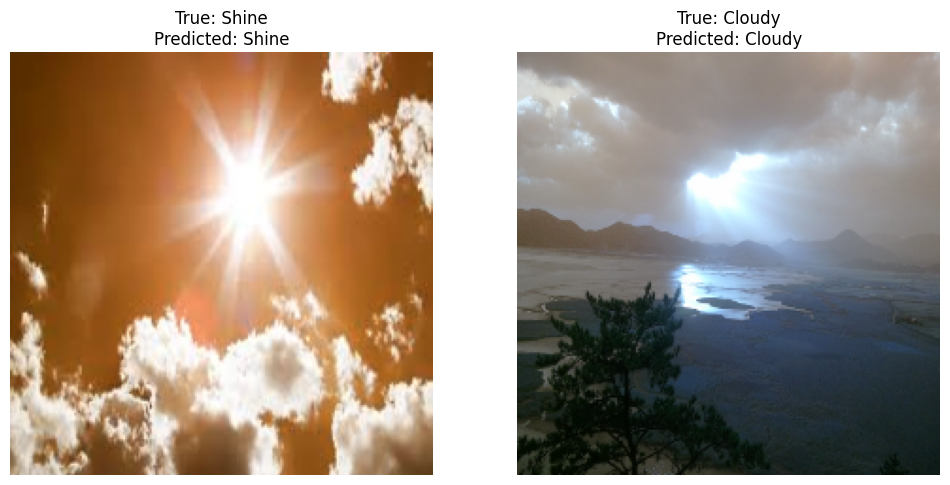

In [44]:
# Test the function with 2 images
predict_and_display_results(model, x_test, y_test, subfolders, num_images=2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Image 1:
True label: Sunrise
Predicted label: Sunrise
Probabilities for each class:
Label Cloudy: 0.0002
Label Rain: 0.0000
Label Shine: 0.0000
Label Sunrise: 0.9998



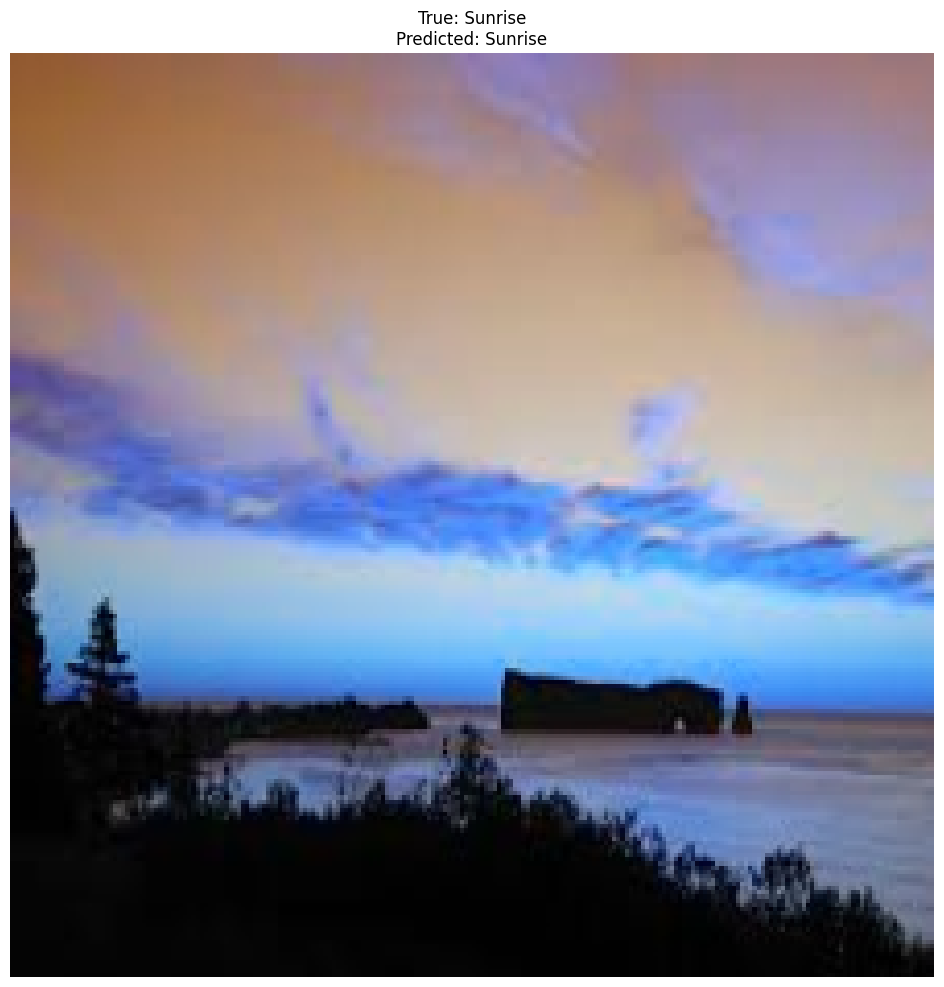

In [54]:
# Test the function with 1 images
predict_and_display_results(model, x_test, y_test, subfolders, num_images=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image 1:
True label: Sunrise
Predicted label: Sunrise
Probabilities for each class:
Label Cloudy: 0.3222
Label Rain: 0.0086
Label Shine: 0.1408
Label Sunrise: 0.5285

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Image 2:
True label: Cloudy
Predicted label: Cloudy
Probabilities for each class:
Label Cloudy: 0.9527
Label Rain: 0.0200
Label Shine: 0.0113
Label Sunrise: 0.0159

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image 3:
True label: Shine
Predicted label: Cloudy
Probabilities for each class:
Label Cloudy: 0.9819
Label Rain: 0.0112
Label Shine: 0.0043
Label Sunrise: 0.0027

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Image 4:
True label: Rain
Predicted label: Cloudy
Probabilities for each class:
Label Cloudy: 0.8325
Label Rain: 0.1124
Label Shine: 0.0464
Label Sunrise: 0.0087

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image 5:
True label: Sunrise
Predicted label: Sunrise
Probabilities for each class:
Label Cloudy: 0.0000
Label Rain: 0.0000
Label Shine: 0.0000
Label S

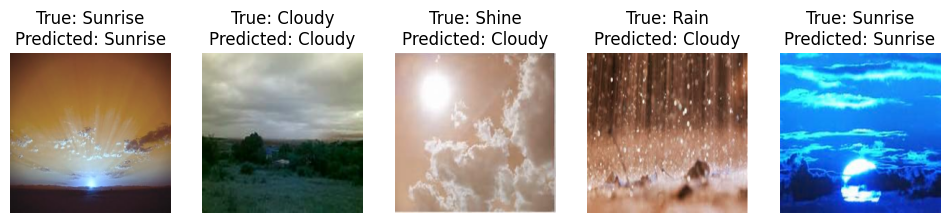

In [52]:
# Test the function with 5 images
predict_and_display_results(model, x_test, y_test, subfolders, num_images=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Image 1:
True label: Rain
Predicted label: Cloudy
Probabilities for each class:
Label Cloudy: 0.8334
Label Rain: 0.1549
Label Shine: 0.0035
Label Sunrise: 0.0082

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Image 2:
True label: Sunrise
Predicted label: Sunrise
Probabilities for each class:
Label Cloudy: 0.0000
Label Rain: 0.0000
Label Shine: 0.0000
Label Sunrise: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image 3:
True label: Sunrise
Predicted label: Sunrise
Probabilities for each class:
Label Cloudy: 0.0000
Label Rain: 0.0000
Label Shine: 0.0000
Label Sunrise: 1.0000



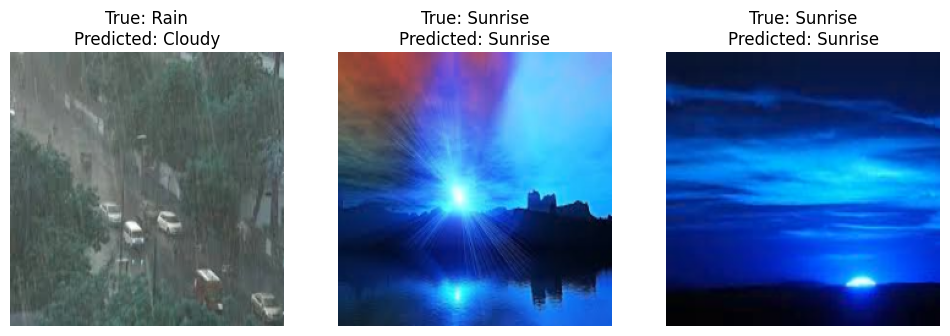

In [47]:
# Test the function with 3 images
predict_and_display_results(model, x_test, y_test, subfolders, num_images=3)